

Objective
Using the data collected from existing customers, build a model that will help the marketing
team identify potential customers who are relatively more likely to subscribe term deposit
and thus increase their hit ratio

Attribute information
Input variables:
Bank client data:
1. age: Continuous feature
2. job: Type of job (management, technician, entrepreneur, blue-collar, etc.)
3. marital: marital status (married, single, divorced)
4. education: education level (primary, secondary, tertiary)
5. default: has credit in default?
6. housing: has housing loan?
7. loan: has personal loan?
8. balance in account
Related to previous contact:
9. contact: contact communication type
10. month: last contact month of year
11. day: last contact day of the month
12. duration: last contact duration, in seconds*
Other attributes:
13. campaign: number of contacts performed during this campaign and for this
client
14. pdays: number of days that passed by after the client was last contacted from a
previous campaign (-1 tells us the person has not been contacted or contact
period is beyond 900 days)
15. previous: number of contacts performed before this campaign and for this
client
16. poutcome: outcome of the previous marketing campaign
Output variable (desired target):
17. Target: Tell us has the client subscribed a term deposit. (Yes, No)



In [1]:
pip install chart-studio

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
#Downloading all necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', 999)
%matplotlib inline
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from yellowbrick.classifier import ClassificationReport, ROCAUC
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from plotly import tools

plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
#Reading data set

bank_data = pd.read_csv('bank-full.csv')
print('Shape of our data {}'.format(bank_data.shape))
bank_data.dtypes


Shape of our data (45211, 17)


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

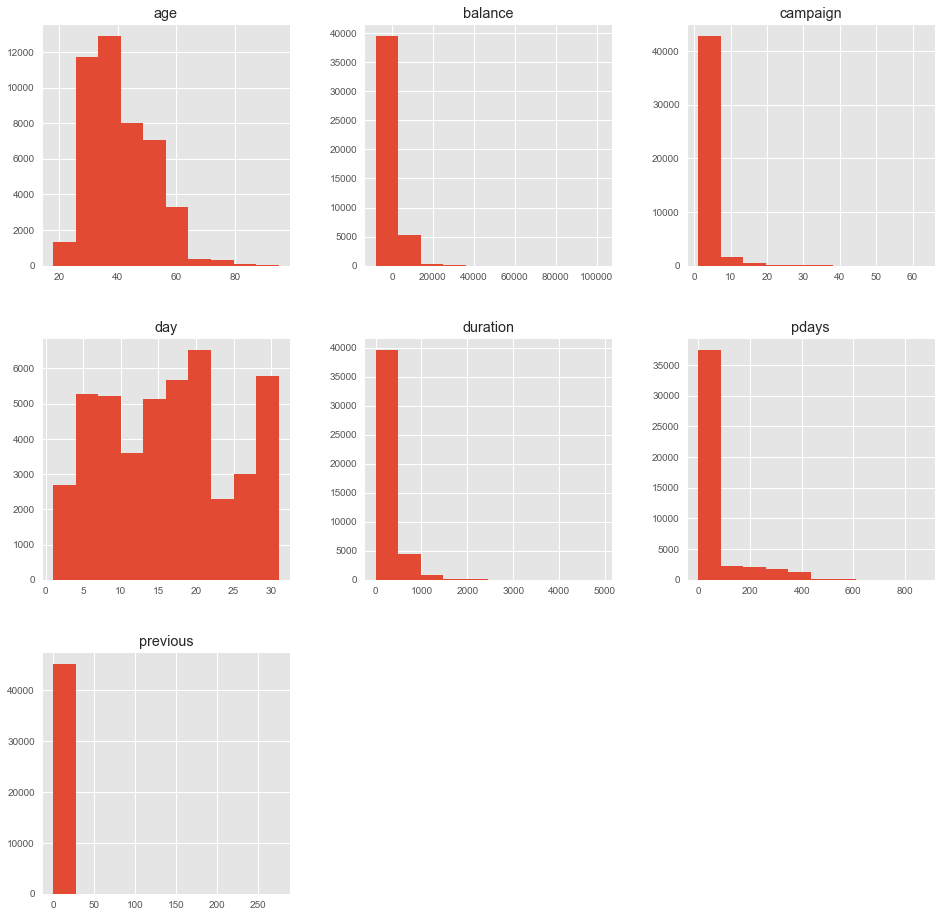

In [5]:
categorical_vars = bank_data.describe(include=["object"]).columns
continuous_vars = bank_data.describe().columns
_ = bank_data.hist(column=continuous_vars, figsize = (16,16))

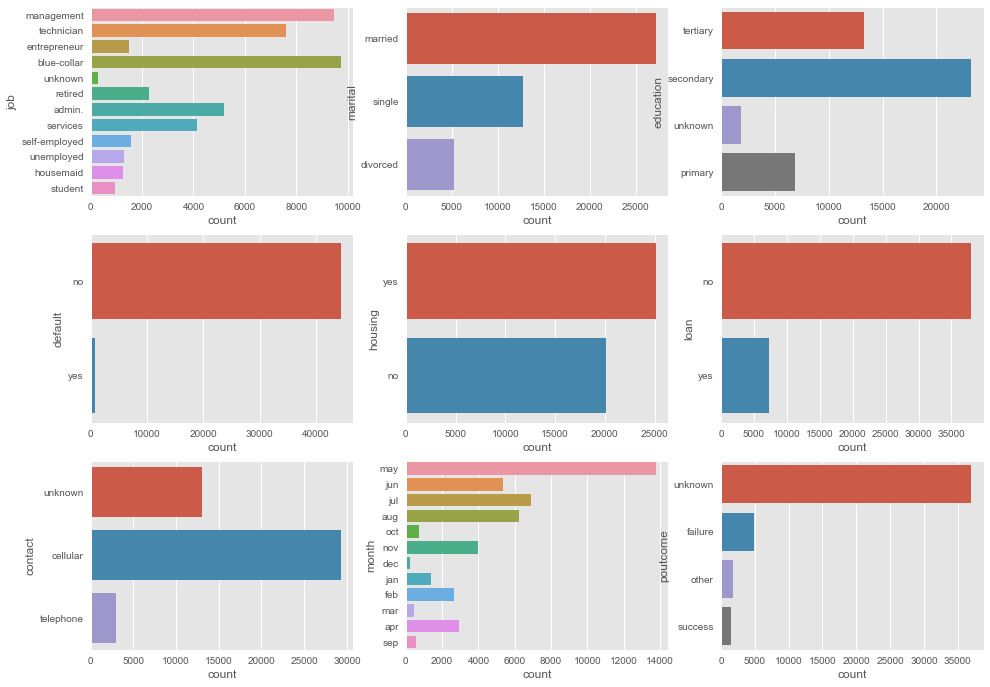

In [6]:
          fig, axes = plt.subplots(4, 3, figsize=(16, 16))
for i, ax in enumerate(axes.ravel()):
    if i > 8:
        ax.set_visible(False)
        continue
    sns.countplot(y = categorical_vars[i], data=bank_data, ax=ax)

In [7]:
#Printing first 10 observations
bank_data.head(10)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [8]:
#Determine datatypes
bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

In [9]:
#Figure out shape of the dataset
bank_data.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
count,"45,211.00",45211,45211,45211,45211,"45,211.00",45211,45211,45211,"45,211.00",45211,"45,211.00","45,211.00","45,211.00","45,211.00",45211,45211
unique,nan,12,3,4,2,nan,2,2,3,nan,12,nan,nan,nan,nan,4,2
top,nan,blue-collar,married,secondary,no,nan,yes,no,cellular,nan,may,nan,nan,nan,nan,unknown,no
freq,nan,9732,27214,23202,44396,nan,25130,37967,29285,nan,13766,nan,nan,nan,nan,36959,39922
mean,40.94,NaN,NaN,NaN,NaN,"1,362.27",NaN,NaN,NaN,15.81,NaN,258.16,2.76,40.20,0.58,NaN,NaN
std,10.62,NaN,NaN,NaN,NaN,"3,044.77",NaN,NaN,NaN,8.32,NaN,257.53,3.10,100.13,2.30,NaN,NaN
min,18.00,NaN,NaN,NaN,NaN,"-8,019.00",NaN,NaN,NaN,1.00,NaN,0.00,1.00,-1.00,0.00,NaN,NaN
25%,33.00,NaN,NaN,NaN,NaN,72.00,NaN,NaN,NaN,8.00,NaN,103.00,1.00,-1.00,0.00,NaN,NaN
50%,39.00,NaN,NaN,NaN,NaN,448.00,NaN,NaN,NaN,16.00,NaN,180.00,2.00,-1.00,0.00,NaN,NaN
75%,48.00,NaN,NaN,NaN,NaN,"1,428.00",NaN,NaN,NaN,21.00,NaN,319.00,3.00,-1.00,0.00,NaN,NaN


In [10]:
#Perform descriptive analysis
bank_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,"45,211.00",40.94,10.62,18.00,33.00,39.00,48.00,95.00
balance,"45,211.00","1,362.27","3,044.77","-8,019.00",72.00,448.00,"1,428.00","102,127.00"
day,"45,211.00",15.81,8.32,1.00,8.00,16.00,21.00,31.00
duration,"45,211.00",258.16,257.53,0.00,103.00,180.00,319.00,"4,918.00"
campaign,"45,211.00",2.76,3.10,1.00,1.00,2.00,3.00,63.00
pdays,"45,211.00",40.20,100.13,-1.00,-1.00,-1.00,-1.00,871.00
previous,"45,211.00",0.58,2.30,0.00,0.00,0.00,0.00,275.00


In [11]:
#Univariate Analysis
##Check for nulls
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

In [12]:
data_dummies_bank_data = pd.get_dummies(bank_data, columns=categorical_vars, drop_first=True)


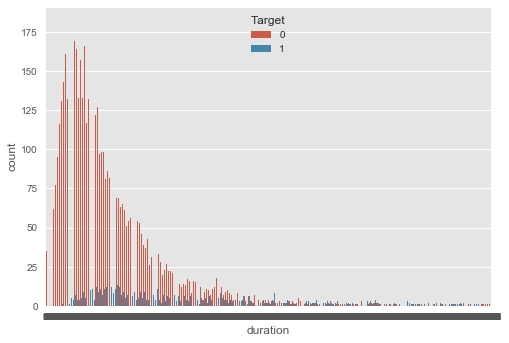

In [82]:
sns.countplot(x='duration', data=bank_data,hue='Target')

Text(0.5, 0, 'Target')

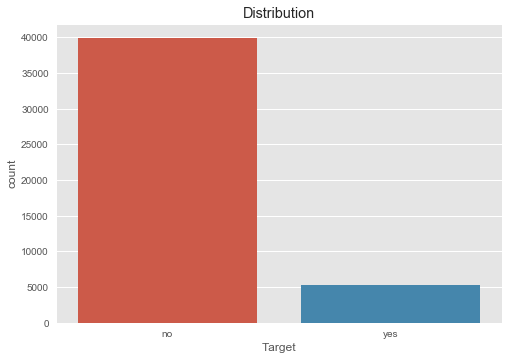

In [13]:
from matplotlib import pyplot as plt
sns.countplot(x=bank_data['Target'])
plt.title('Distribution')
plt.xlabel('Target')

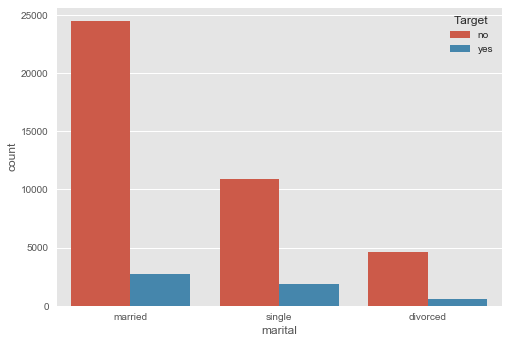

In [14]:
sns.countplot(x='marital', data=bank_data,hue='Target')


In [15]:
groups = [bank_data]
for column in groups:
    column.loc[column["age"] < 30,  'age_group'] = 30
    column.loc[(column["age"] >= 30) & (column["age"] <= 44), 'age_group'] = 40
    column.loc[(column["age"] >= 45) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60
    
Age_resp_perc = pd.crosstab(bank_data['Target'],bank_data['age_group']).apply(lambda x: x/x.sum() * 100)
Age_resp_perc= Age_resp_perc.transpose()

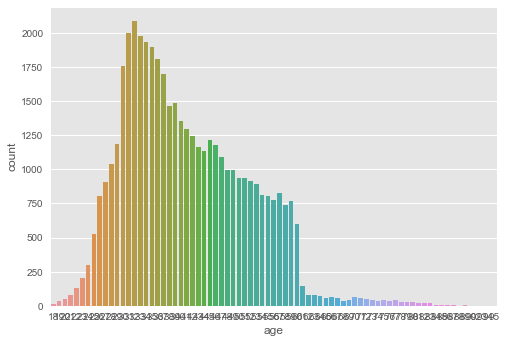

In [16]:
sns.countplot(x = 'age', data = bank_data)

In [17]:
print('1º Quartile: ', bank_data['age'].quantile(q = 0.25))
print('2º Quartile: ', bank_data['age'].quantile(q = 0.50))
print('3º Quartile: ', bank_data['age'].quantile(q = 0.75))
print('4º Quartile: ', bank_data['age'].quantile(q = 1.00))
#Calculate the outliers:Interquartile range, IQR = Q3 - Q1
                      # lower 1.5*IQR = Q1 - 1.5 * IQR 
                      # Upper 1.5*IQR = Q3 + 1.5 * IQR
print('Ages above: ', bank_data['age'].quantile(q = 0.75) + 
                      1.5*(bank_data['age'].quantile(q = 0.75) - bank_data['age'].quantile(q = 0.25)), 'are outliers')
print('# of outliers: ', bank_data[bank_data['age'] > 70.5]['age'].count())
print('# of clients: ', len(bank_data))
#Outliers in %
print('Outliers are:', round(bank_data[bank_data['age'] > 69.6]['age'].count()*100/len(bank_data),2), '%')

1º Quartile:  33.0
2º Quartile:  39.0
3º Quartile:  48.0
4º Quartile:  95.0
Ages above:  70.5 are outliers
# of outliers:  487
# of clients:  45211
Outliers are: 1.23 %


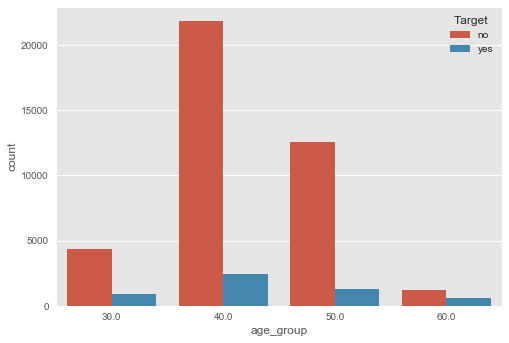

In [18]:
sns.countplot(x='age_group', data=bank_data, hue='Target')
#Clients between 40 and 50 seem to be interested in opening long term deposits

In [19]:
#Success rate def depends on education and marital status

In [20]:
bank_data.loc[bank_data.Target == "yes", 'subscribe'] = 1
bank_data.loc[bank_data.Target == "no", 'subscribe'] = 0

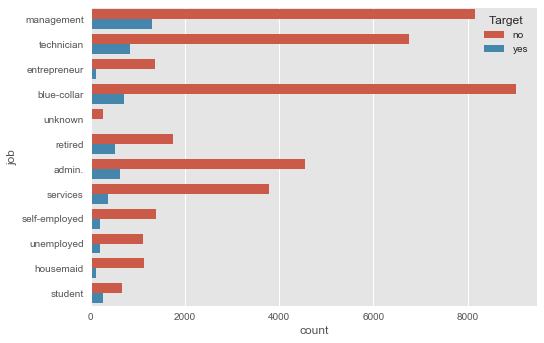

In [21]:
sns.countplot(y='job', data=bank_data,hue='Target')
#Although blue-collar, management and technicians are more likely to be in our population, students are more likely to open long-term deposit, which is proved by calculating success rate:
SR=

In [91]:

table = PrettyTable(['Job', 'Clients', 'Success rate'])
table.add_row(['Blue-collar', len(bank_data[bank_data['job'] == 'blue-collar']), bank_data[bank_data['job'] == 'blue-collar'].Target.value_counts()[1]/len(bank_data[bank_data['job'] == 'blue-collar'])])
table.add_row(['Student', len(bank_data[bank_data['job'] == 'student']), bank_data[bank_data['job'] == 'student'].Target.value_counts()[1]/len(bank_data[bank_data['job'] == 'student'])])


print(table)

+-------------+---------+--------------------+
|     Job     | Clients |    Success rate    |
+-------------+---------+--------------------+
| Blue-collar |   9975  | 0.0737844611528822 |
|   Student   |   938   | 0.2867803837953092 |
+-------------+---------+--------------------+


Text(0.5, 1.0, 'Count Plot of poutcome for target variable')

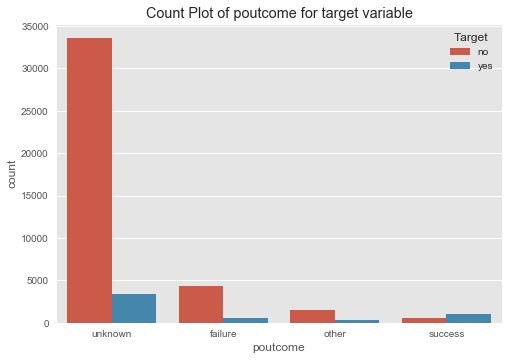

In [22]:

sns.countplot(x=bank_data['poutcome'], data=bank_data, hue=bank_data['Target'])
plt.title('Count Plot of poutcome for target variable')
#Most had previous outcome as unknown

Text(0.5, 1.0, 'Count Plot of education for target variable')

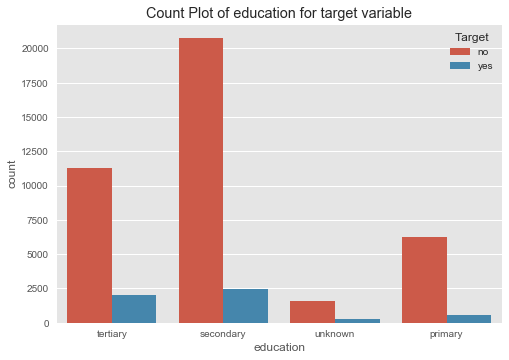

In [23]:

sns.countplot(x=bank_data['education'], data=bank_data, hue=bank_data['Target'])
plt.title('Count Plot of education for target variable')
#Most had secondary education

Text(0.5, 1.0, 'Count Plot of default for target variable')

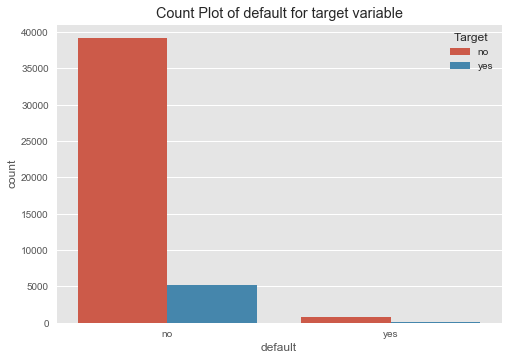

In [24]:

sns.countplot(x=bank_data['default'], data=bank_data, hue=bank_data['Target'])
plt.title('Count Plot of default for target variable')
#Most clients never defaulted

Text(0.5, 1.0, 'Count Plot by month for target variable')

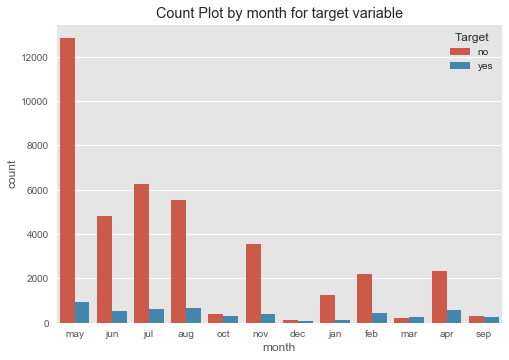

In [25]:

sns.countplot(x=bank_data['month'], data=bank_data, hue=bank_data['Target'])
plt.title('Count Plot by month for target variable')

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

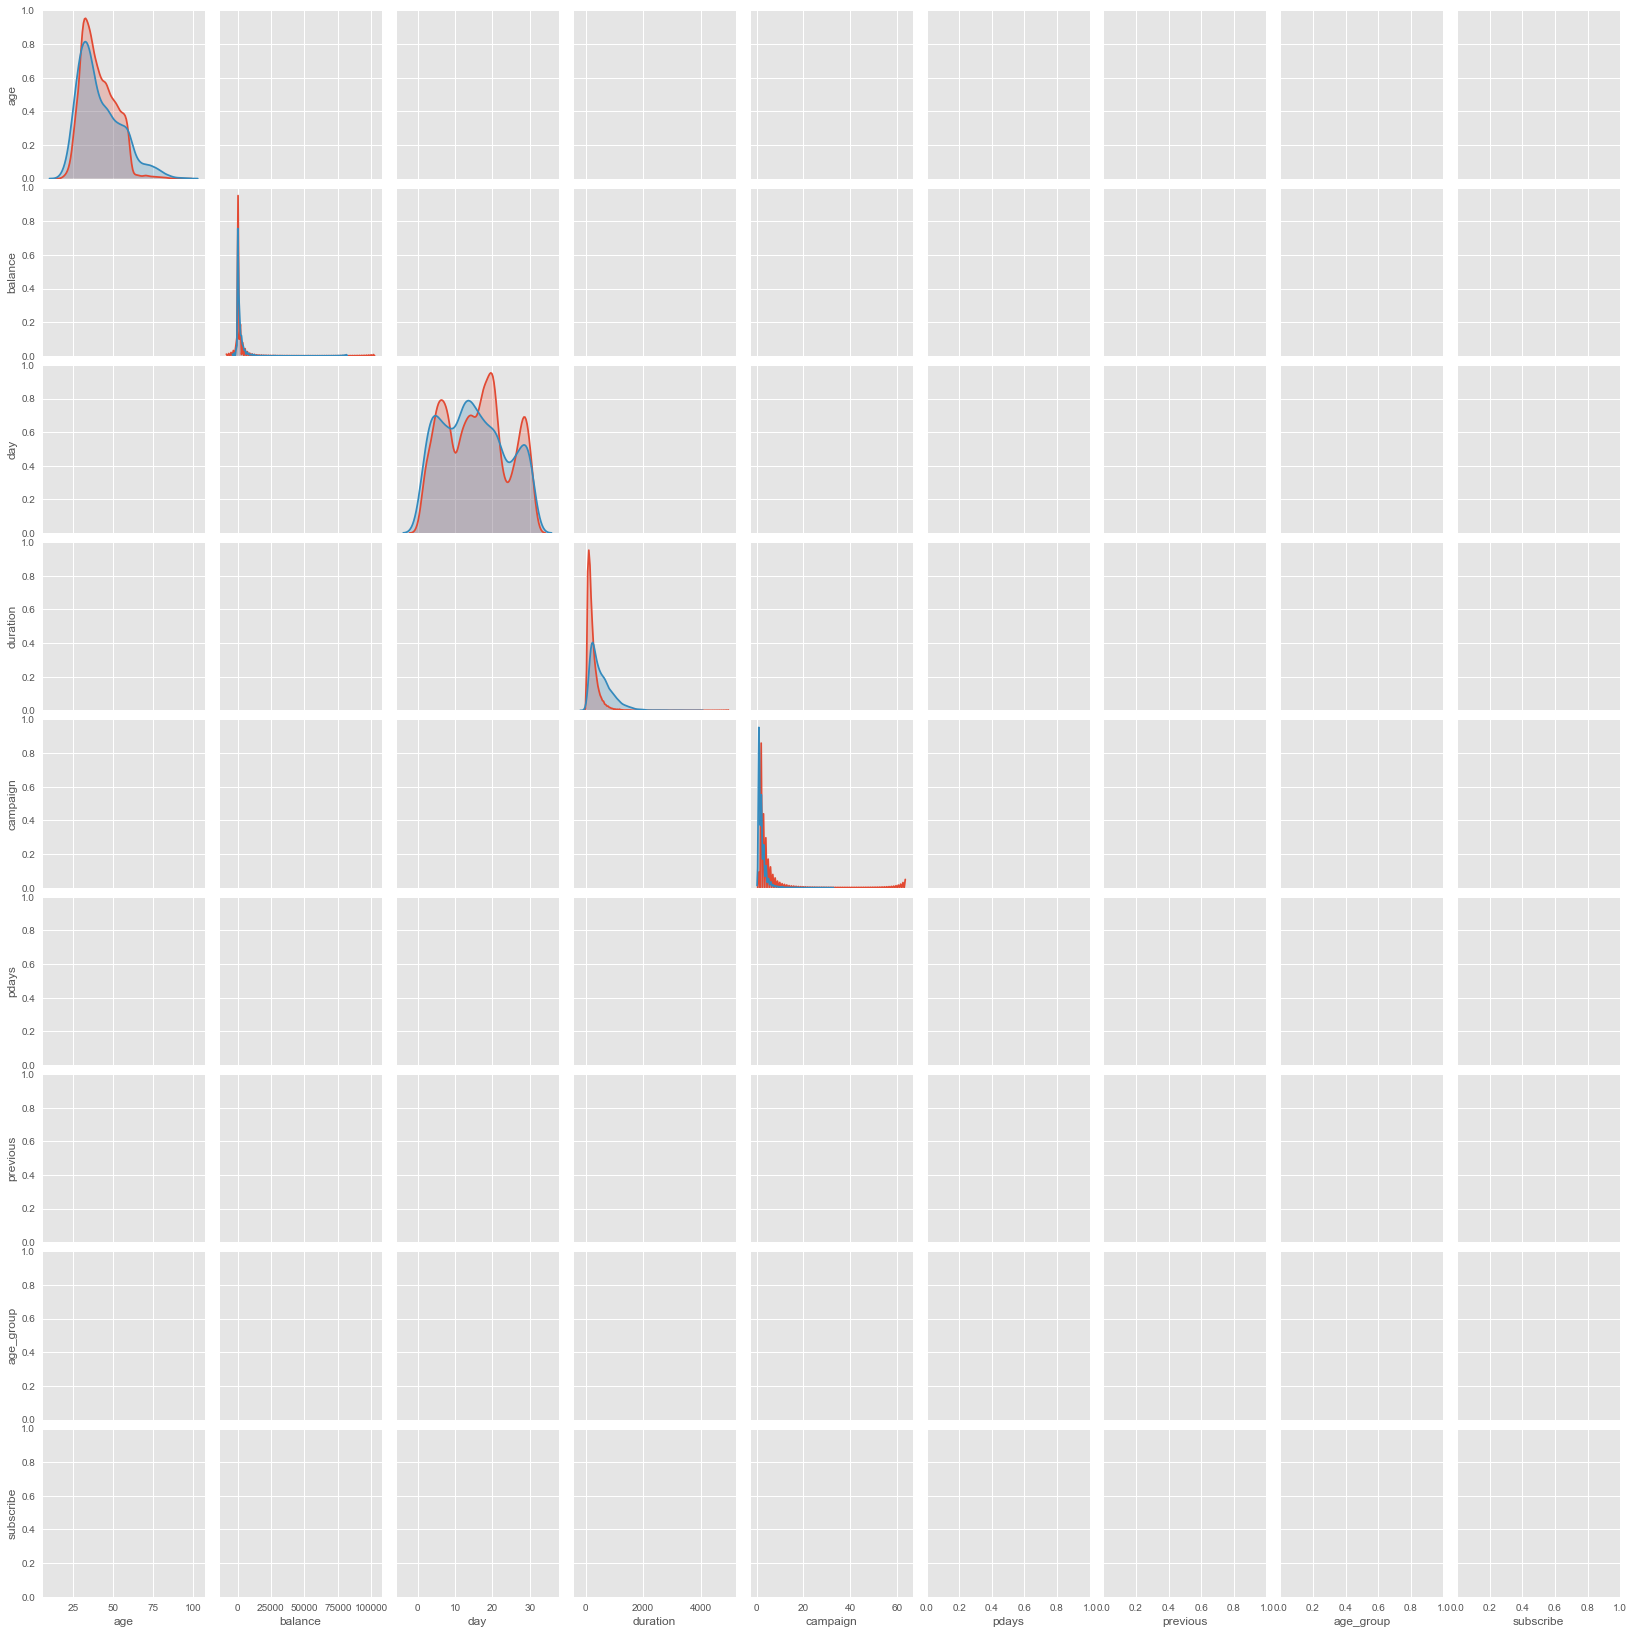

In [26]:
sns.pairplot(bank_data, hue='Target') ##For some reason was not able to build one...would need figure out why

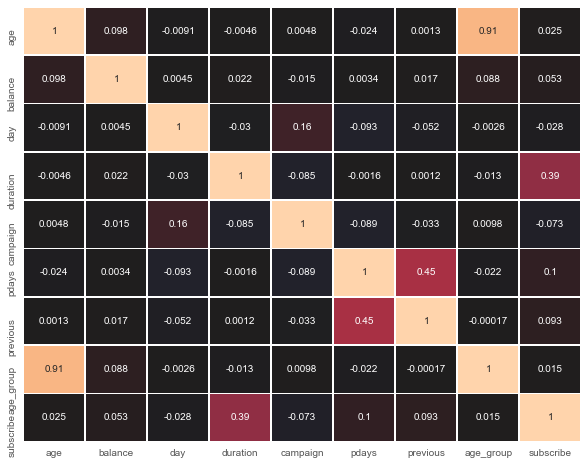

In [27]:
#Bivariate analysis
plt.figure(figsize=(10,8))

sns.heatmap(bank_data.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False)

plt.show()

In [28]:

bank_data['Target'].value_counts()

no     39922
yes     5289
Name: Target, dtype: int64

In [29]:
bank_data.corr()

,age,balance,day,duration,campaign,pdays,previous,age_group,subscribe
age,1.00,0.10,-0.01,-0.00,0.00,-0.02,0.00,0.91,0.03
balance,0.10,1.00,0.00,0.02,-0.01,0.00,0.02,0.09,0.05
day,-0.01,0.00,1.00,-0.03,0.16,-0.09,-0.05,-0.00,-0.03
duration,-0.00,0.02,-0.03,1.00,-0.08,-0.00,0.00,-0.01,0.39
campaign,0.00,-0.01,0.16,-0.08,1.00,-0.09,-0.03,0.01,-0.07
pdays,-0.02,0.00,-0.09,-0.00,-0.09,1.00,0.45,-0.02,0.10
previous,0.00,0.02,-0.05,0.00,-0.03,0.45,1.00,-0.00,0.09
age_group,0.91,0.09,-0.00,-0.01,0.01,-0.02,-0.00,1.00,0.01
subscribe,0.03,0.05,-0.03,0.39,-0.07,0.10,0.09,0.01,1.00


In [30]:
bank_data['Target'].value_counts()

no     39922
yes     5289
Name: Target, dtype: int64

In [31]:
bank_data['education'].value_counts()


secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [32]:
bank_data['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [40]:
def cross_tab(df,f1,f2):
    jobs=list(bank_data[f1].unique())
    edu=list(bank_data[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=bank_data[bank_data[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

In [41]:
cross_tab(bank_data,'job','education')

,tertiary,secondary,primary
admin.,572.00,4390,209.00
blue-collar,149.00,5896,"3,809.00"
entrepreneur,762.00,542,183.00
housemaid,173.00,395,672.00
management,"8,079.00",1121,294.00
retired,369.00,1109,795.00
self-employed,872.00,577,130.00
services,202.00,3607,345.00
student,223.00,671,44.00
technician,"1,968.00",5471,158.00


In [34]:
##Eliminated unknown by replacing them 
bank_data['job'][bank_data['age']>67].value_counts()

retired          556
management        21
housemaid         20
technician        10
unknown            9
self-employed      6
blue-collar        4
admin.             4
entrepreneur       3
services           1
Name: job, dtype: int64

In [42]:

bank_data.loc[(bank_data['age']>67) & (bank_data['job']=='unknown'), 'job'] = 'retired'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='management'), 'education'] = 'tertiary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='services'), 'education'] = 'secondary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='housemaid'), 'education'] = 'primary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='admin.'), 'education'] = 'secondary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='blue-collar'), 'education'] = 'secondary'
bank_data.loc[(bank_data['job'] == 'unknown') & (bank_data['education']=='primary'), 'job'] = 'blue-collar'
bank_data.loc[(bank_data['job'] == 'unknown') & (bank_data['education']=='secondary'), 'job'] = 'blue-collar'
bank_data.loc[(bank_data['job'] == 'unknown') & (bank_data['education']=='tertiary'), 'job'] = 'management'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='entrepreneur'), 'education'] = 'tertiary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='retired'), 'education'] = 'secondary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='self-employed'), 'education'] = 'tertiary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='technician'), 'education'] = 'secondary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='student'), 'education'] = 'secondary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='unknown'), 'education'] = 'secondary'
bank_data.loc[(bank_data['education']=='unknown') & (bank_data['job']=='unemployed'), 'education'] = 'secondary'

In [43]:
cross_tab(bank_data,'job','education')

,tertiary,secondary,primary
job,,,
admin.,572,4390,209
blue-collar,149,6017,3809
entrepreneur,762,542,183
housemaid,173,395,672
management,8079,1121,294
retired,369,1109,795
self-employed,872,577,130
services,202,3607,345
student,223,671,44


In [44]:
cross_tab(bank_data,'job','housing')


,yes,no
job,,
admin.,3182,1989
blue-collar,7071,2904
entrepreneur,869,618
housemaid,398,842
management,4681,4813
retired,491,1782
self-employed,765,814
services,2766,1388
student,249,689


In [45]:
numerical_variables = ['age','campaign', 'pdays', 'previous', 'balance','duration']
bank_data[numerical_variables].describe()

,age,campaign,pdays,previous,balance,duration
count,"45,211.00","45,211.00","45,211.00","45,211.00","45,211.00","45,211.00"
mean,40.94,2.76,40.20,0.58,"1,362.27",258.16
std,10.62,3.10,100.13,2.30,"3,044.77",257.53
min,18.00,1.00,-1.00,0.00,"-8,019.00",0.00
25%,33.00,1.00,-1.00,0.00,72.00,103.00
50%,39.00,2.00,-1.00,0.00,448.00,180.00
75%,48.00,3.00,-1.00,0.00,"1,428.00",319.00
max,95.00,63.00,871.00,275.00,"102,127.00","4,918.00"


In [46]:

bank_data.replace(to_replace={'Target':'yes'}, value=1, inplace=True)
bank_data.replace(to_replace={'Target':'no'}, value=0, inplace=True)

In [47]:
data1=bank_data.copy()

data1['job'] = data1['job'].astype('category').cat.codes
data1['marital'] = data1['marital'].astype('category').cat.codes
data1['education'] = data1['education'].astype('category').cat.codes
data1['contact'] = data1['contact'].astype('category').cat.codes
data1['poutcome'] = data1['poutcome'].astype('category').cat.codes
data1['month'] = data1['month'].astype('category').cat.codes
data1['default'] = data1['default'].astype('category').cat.codes
data1['loan'] = data1['loan'].astype('category').cat.codes
data1['housing'] = data1['housing'].astype('category').cat.codes

In [48]:
y = data1['Target']
x_train, x_test, y_train, y_test = train_test_split(bank_data.drop(['Target'], axis=1), y, test_size=0.30, random_state=42)

In [49]:

print('Train data shape {} {}'.format(x_train.shape, y_train.shape))
print('Test data shape {} {}'.format(x_test.shape, y_test.shape))

Train data shape (31647, 18) (31647,)
Test data shape (13564, 18) (13564,)


Important features we are going to consider for machine learning models:

duration (the most strongest correlation from the heatmap)
contact
poutcome
month
housing
pdays
age
balance

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=x_train.poutcome.unique())
x_train_poutcome = vectorizer.fit_transform(x_train.poutcome)
x_test_poutcome = vectorizer.transform(x_test.poutcome)

In [51]:
vectorizer = CountVectorizer(vocabulary=x_train.contact.unique())
x_train_contact = vectorizer.fit_transform(x_train.contact)
x_test_contact = vectorizer.transform(x_test.contact)

In [52]:
vectorizer = CountVectorizer(vocabulary=x_train.month.unique())
x_train_month = vectorizer.fit_transform(x_train.month)
x_test_month = vectorizer.transform(x_test.month)

In [53]:
vectorizer = CountVectorizer(vocabulary=x_train.housing.unique())
x_train_housing = vectorizer.fit_transform(x_train.housing)
x_test_housing = vectorizer.transform(x_test.housing)

In [54]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
vectorizer = Normalizer()
x_train_duration = vectorizer.fit_transform(x_train.duration.values.reshape(1,-1)).transpose()
x_test_duration = vectorizer.transform(x_test.duration.values.reshape(1, -1)).transpose()

In [55]:
vectorizer = Normalizer()
x_train_pdays = vectorizer.fit_transform(x_train.pdays.values.reshape(1,-1)).transpose()
x_test_pdays = vectorizer.transform(x_test.pdays.values.reshape(1, -1)).transpose()

In [56]:

vectorizer = Normalizer()
x_train_age = vectorizer.fit_transform(x_train.age.values.reshape(1,-1)).transpose()
x_test_age = vectorizer.transform(x_test.age.values.reshape(1, -1)).transpose()

In [57]:
vectorizer = Normalizer()
x_train_balance = vectorizer.fit_transform(x_train.balance.values.reshape(1,-1)).transpose()
x_test_balance = vectorizer.transform(x_test.balance.values.reshape(1, -1)).transpose()

In [58]:
from scipy.sparse import hstack

train = hstack((x_train_contact, x_train_poutcome, x_train_month, x_train_housing, x_train_duration, x_train_pdays, x_train_age, x_train_balance)).tocsr()

test = hstack((x_test_contact, x_test_poutcome, x_test_month, x_test_housing, x_test_duration, x_test_pdays, x_test_age, x_test_balance)).tocsr()

In [59]:
bankdata_score = {}

In [60]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'C':[(10**i)*x for i in range(-4, 1) for x in [1,3,5]]}

model = LogisticRegression(class_weight='balanced')
clf = RandomizedSearchCV(model, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(train, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))


Best parameters:  {'C': 1}
Best score: 0.8075516818167952


In [78]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
dmodel = SGDClassifier(alpha=0.0001, class_weight='balanced', n_jobs=-1)
model.fit(train, y_train)
y_probs_train = model.decision_function(train)

y_probs_test = model.decision_function(test)
y_predicted_train = model.predict(train)
y_predicted_test = model.predict(test)

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
test_auc = roc_auc_score(y_test, y_probs_test)
train_acc = accuracy_score(y_train, y_predicted_train)
test_acc = accuracy_score(y_test, y_predicted_test)


print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('Test AUC: %.3f' % test_auc)
print('*'*50)
print('Train Accuracy: %.3f' % train_acc)
print('Test Accuracy: %.3f' % test_acc)

bankdata_score['SVM'] = [test_auc, test_acc]
from sklearn.metrics import roc_curve
# CALC ROC curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the ROC curve
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(test_fpr, test_tpr, marker='.', label='Test AUC')
plt.legend()
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve")
plt.show()

SyntaxError: invalid syntax (<ipython-input-78-d90e42652592>, line 19)

Confusion matrix:
 [[23373  4583]
 [ 1272  2419]]


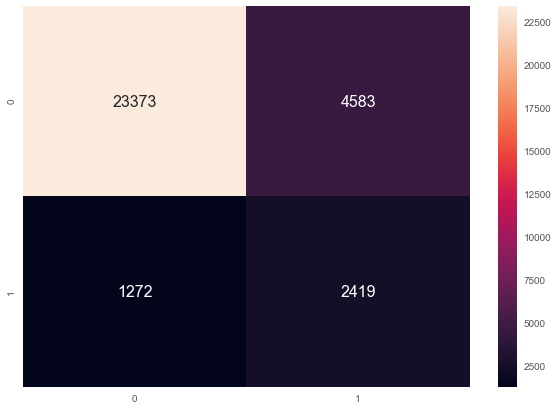

In [62]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion matrix:
 [[9607 2359]
 [ 449 1149]]


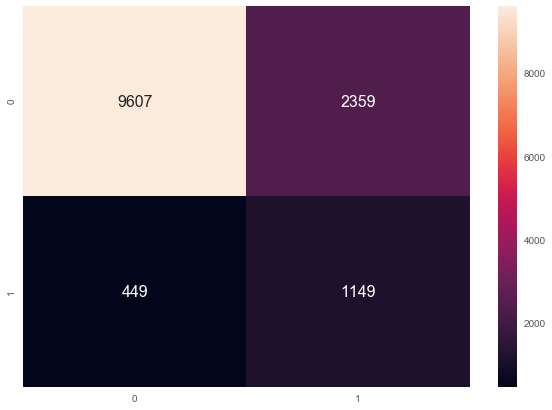

In [63]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_test, y_predicted_test)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**************************************************
Train AUC: 0.999
Test AUC: 0.873
**************************************************
Train Accuracy: 0.883
Test Accuracy: 0.882
**************************************************
Train F1: 0.000
Test F1: 0.000


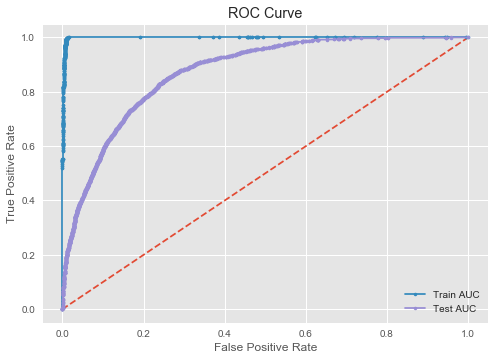

In [77]:
from sklearn.calibration import CalibratedClassifierCV
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from mlxtend.classifier import StackingClassifier

model_1 = LogisticRegression(C=3, class_weight='balanced', n_jobs=-1)
model_1.fit(train, y_train)
clf_1 = CalibratedClassifierCV(model_1, method='sigmoid')

model_2 = RandomForestClassifier(n_estimators=250, max_depth=25, class_weight='balanced', n_jobs=-1)
model_2.fit(train, y_train)
clf_2 = CalibratedClassifierCV(model_2, method='sigmoid')

model_3 = SGDClassifier(alpha=0.0001, class_weight='balanced', n_jobs=-1)
model_3.fit(train, y_train)
clf_3 = CalibratedClassifierCV(model_3, method='sigmoid')


C = [0.0001,0.001,0.01,0.1,1,10]
roc = 0
best_C = 0
for i in C:
    log_reg = LogisticRegression(C=i, n_jobs=-1)
    model = StackingClassifier(classifiers=[clf_1, clf_2, clf_3], meta_classifier=log_reg, use_probas=True)
    model.fit(train, y_train)
    model_roc = roc_auc_score(y_test, model.predict_proba(test)[:, 1])
    if roc < model_roc:
        roc = model_roc
        best_C = i
log_reg = LogisticRegression(C=0.0001, n_jobs=-1)
stack_clf = StackingClassifier(classifiers=[clf_1, clf_2, clf_3], meta_classifier=log_reg, use_probas=True)
stack_clf.fit(train, y_train)

y_probs_train = stack_clf.predict_proba(train)
y_probs_test = stack_clf.predict_proba(test)
y_predicted_train = stack_clf.predict(train)
y_predicted_test = stack_clf.predict(test)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_test = y_probs_test[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
test_auc = roc_auc_score(y_test, y_probs_test)
train_acc = accuracy_score(y_train, y_predicted_train)
test_acc = accuracy_score(y_test, y_predicted_test)


print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('Test AUC: %.3f' % test_auc)
print('*'*50)
print('Train Accuracy: %.3f' % train_acc)
print('Test Accuracy: %.3f' % test_acc)

bankdata_score['Stacking Classifier'] = [test_auc, test_acc]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the stack_clf
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(test_fpr, test_tpr, marker='.', label='Test AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
from xgboost import XGBClassifier

params = {'max_depth': [5, 10, 15], 'n_estimators': [10, 100, 500]}

model = XGBClassifier(class_weight='balanced', n_jobs=-1)
clf = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1, return_train_score=True)
clf.fit(train, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=5, n_estimators=100 ,class_weight='balanced', n_jobs=-1)
model.fit(train, y_train)
y_probs_train = model.predict_proba(train)
y_probs_test = model.predict_proba(test)
y_predicted_train = model.predict(train)
y_predicted_test = model.predict(test)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_test = y_probs_test[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
test_auc = roc_auc_score(y_test, y_probs_test)
train_acc = accuracy_score(y_train, y_predicted_train)
test_acc = accuracy_score(y_test, y_predicted_test)


print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('Test AUC: %.3f' % test_auc)
print('*'*50)
print('Train Accuracy: %.3f' % train_acc)
print('Test Accuracy: %.3f' % test_acc)

bankdata_score['XGBoost'] = [test_auc, test_acc,test_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(test_fpr, test_tpr, marker='.', label='Test AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [81]:
from prettytable import PrettyTable
print('Model Comparision and Summary')
table = PrettyTable(['Model', 'AUC', 'Accuracy'])
for item in bankdata_score.items():
    table.add_row([item[0], item[1][0], item[1][1]])
print(table)

Model Comparision and Summary
+---------------------+--------------------+--------------------+
|        Model        |        AUC         |      Accuracy      |
+---------------------+--------------------+--------------------+
|         SVM         | 0.8220153179105505 | 0.8560159245060455 |
| Stacking Classifier | 0.8728845203253188 | 0.8821881450899439 |
|       XGBoost       | 0.8793831427258333 | 0.8479799469183131 |
+---------------------+--------------------+--------------------+


Conclusion:
    1)the dataset was very unbalanced, it was challenging to deal with NaN values
    2)i was not able to make pairplot work (see line 26)
    3)the best model turned out to be Stacking
    4) i was not able to calculate f1 score....still not sure why
    
    
